In [1]:
import astropy.constants as c


In [2]:
import hapi as hp

HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:875: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:964: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:991: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:1149: SyntaxWarning: invalid escape sequence '\d'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:1303: SyntaxWarning: invalid escape sequence '\.'
/Us

In [248]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='jshtml')
from scipy.optimize import curve_fit
from scipy.special import erf
import uncertainties as unc
import astropy.constants as c

pd.set_option('display.max_columns', None)
from IPython.display import set_matplotlib_formats
from matplotlib.ticker import ScalarFormatter

#set_matplotlib_formats("png")
plt.rc("xtick", labelsize=16, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=16, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=16) #Font og fontstørrelse
plt.rc("figure",figsize=(14, 8),dpi=250) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # This forces scientific notation

# Set before plotting
# plt.tick_params(direction="in", top=True, right=True, labelsize=15)


In [249]:
# First scan started 10:05 09-10-2024. The data should have to loops 
# Seems like the crystals take more than 5 minutes to warm up as stated in the manual 

In [271]:
df = pd.read_csv("wavelength_scan_data/wavelength_scan_09_10_2024_01.dat", delimiter="\t")

Calculation to go from pump and signal to the idler, i.e. the output wavelength of the OPA stage:

$\lambda_{\text{idler}} = \left( \frac{1}{\lambda_{\text{pump}}} - \frac{1}{\lambda_{\text{signal}}} \right)^{-1}$


In [272]:
def wavelength_idler_w_unc(lambda_pump: float) -> (float, float):
    lambda_signal = 1064.460  # nm
    lambda_signal_unc = 0.001  # nm
    lambda_pump_unc = 0.5  # nm
    
    lambda_pump_float = unc.ufloat(lambda_pump, lambda_pump_unc)
    lambda_signal_float = unc.ufloat(lambda_signal, lambda_signal_unc)
    
    lambda_idler = (1 / lambda_pump_float - 1 / lambda_signal_float)**(-1)
    return lambda_idler.n, lambda_idler.s


def wavelength_idler(lambda_pump: float) -> float:
    lambda_signal = 1064.00  # nm
    lambda_signal_unc = 0.001  # nm
    lambda_pump_unc = 0.5  # nm
    
    lambda_pump_float = unc.ufloat(lambda_pump, lambda_pump_unc)
    lambda_signal_float = unc.ufloat(lambda_signal, lambda_signal_unc)
    
    lambda_idler = (1 / lambda_pump_float - 1 / lambda_signal_float)**(-1)
    return lambda_idler


def mid_ir_to_near_ir(lambda_idler: float) -> float:
    lambda_signal = 1064.00  # nm
    
    lambda_pump = (1 / lambda_signal + 1 / lambda_idler)**(-1)
    return lambda_pump

def wavenumber_to_wavelength(wavenumber: float) -> float:
    return 1 / wavenumber * 1e7

def wavelength_to_wavenumber(wavelength: float) -> float:
    return 1 / wavelength * 1e7

In [292]:
# Extra sortation of the data to delete the 846 measurement since it is missing at the end
# Also adding columns with the unc.ufloat types 
df_tot = df.loc[df["Set_value"] != 846].copy()
df_tot["Metex"] = df_tot["Metex"] * 100
df_tot["Std"] = df_tot["Std"] * 100
df_tot["Power"] = df_tot.apply(lambda row: unc.ufloat(row["Metex"], row["Std"]), axis=1)

near_ir_offset = 3.50  # nm
df_tot["Mon_value_offset"] = df_tot["Mon_value"] + near_ir_offset
df_tot["MonWavelengthMidIR"] = df_tot["Mon_value"].apply(lambda x: wavelength_idler(x))
df_tot["MonWavelengthMidIR_offset"] = df_tot["Mon_value_offset"].apply(lambda x: wavelength_idler(x))

In [293]:
mean_wavelength = (df_tot.query("index < 100")["MonWavelengthMidIR"].values + 
                         df_tot.query("index >= 100")["MonWavelengthMidIR"].values) / 2

mean_wavelength_offset = (df_tot.query("index < 100")["MonWavelengthMidIR_offset"].values + 
                          df_tot.query("index >= 100")["MonWavelengthMidIR_offset"].values) / 2

difference_power = (df_tot.query("index < 100")["Power"].values - 
                         df_tot.query("index >= 100")["Power"].values)

mean_power = (df_tot.query("index < 100")["Power"].values + 
                         df_tot.query("index >= 100")["Power"].values) / 2


In [255]:
mean_power[0], df_tot.iloc[0]["Power"], df_tot.iloc[100]["Power"]

(10.804+/-0.8773148194918401,
 5.3260000000000005+/-1.4226,
 16.282+/-1.0271000000000001)

In [256]:
# These values will be used for the uncertainties regarding the divergense measurements
print(f"Uncertainties used for the divergense measurements:")
print()
print(r"Power Range [mW] │ Max Uncertainty Times 2 [mW]")
for i in range(0, 35, 5):
    max_val = max([i.s for i in df_tot.query(f"Metex > {i} & Metex <= {i + 5}")["Power"]])
    if i == 0:
        extra = "  "
    elif i == 5:
        extra = " "
    else:
        extra = ""
    print(f"{i} - {i + 5}        {extra}  │ {max_val * 2:.2f}")


Uncertainties used for the divergense measurements:

Power Range [mW] │ Max Uncertainty Times 2 [mW]
0 - 5            │ 1.41
5 - 10           │ 2.85
10 - 15          │ 4.07
15 - 20          │ 7.22
20 - 25          │ 5.37
25 - 30          │ 5.28
30 - 35          │ 5.95


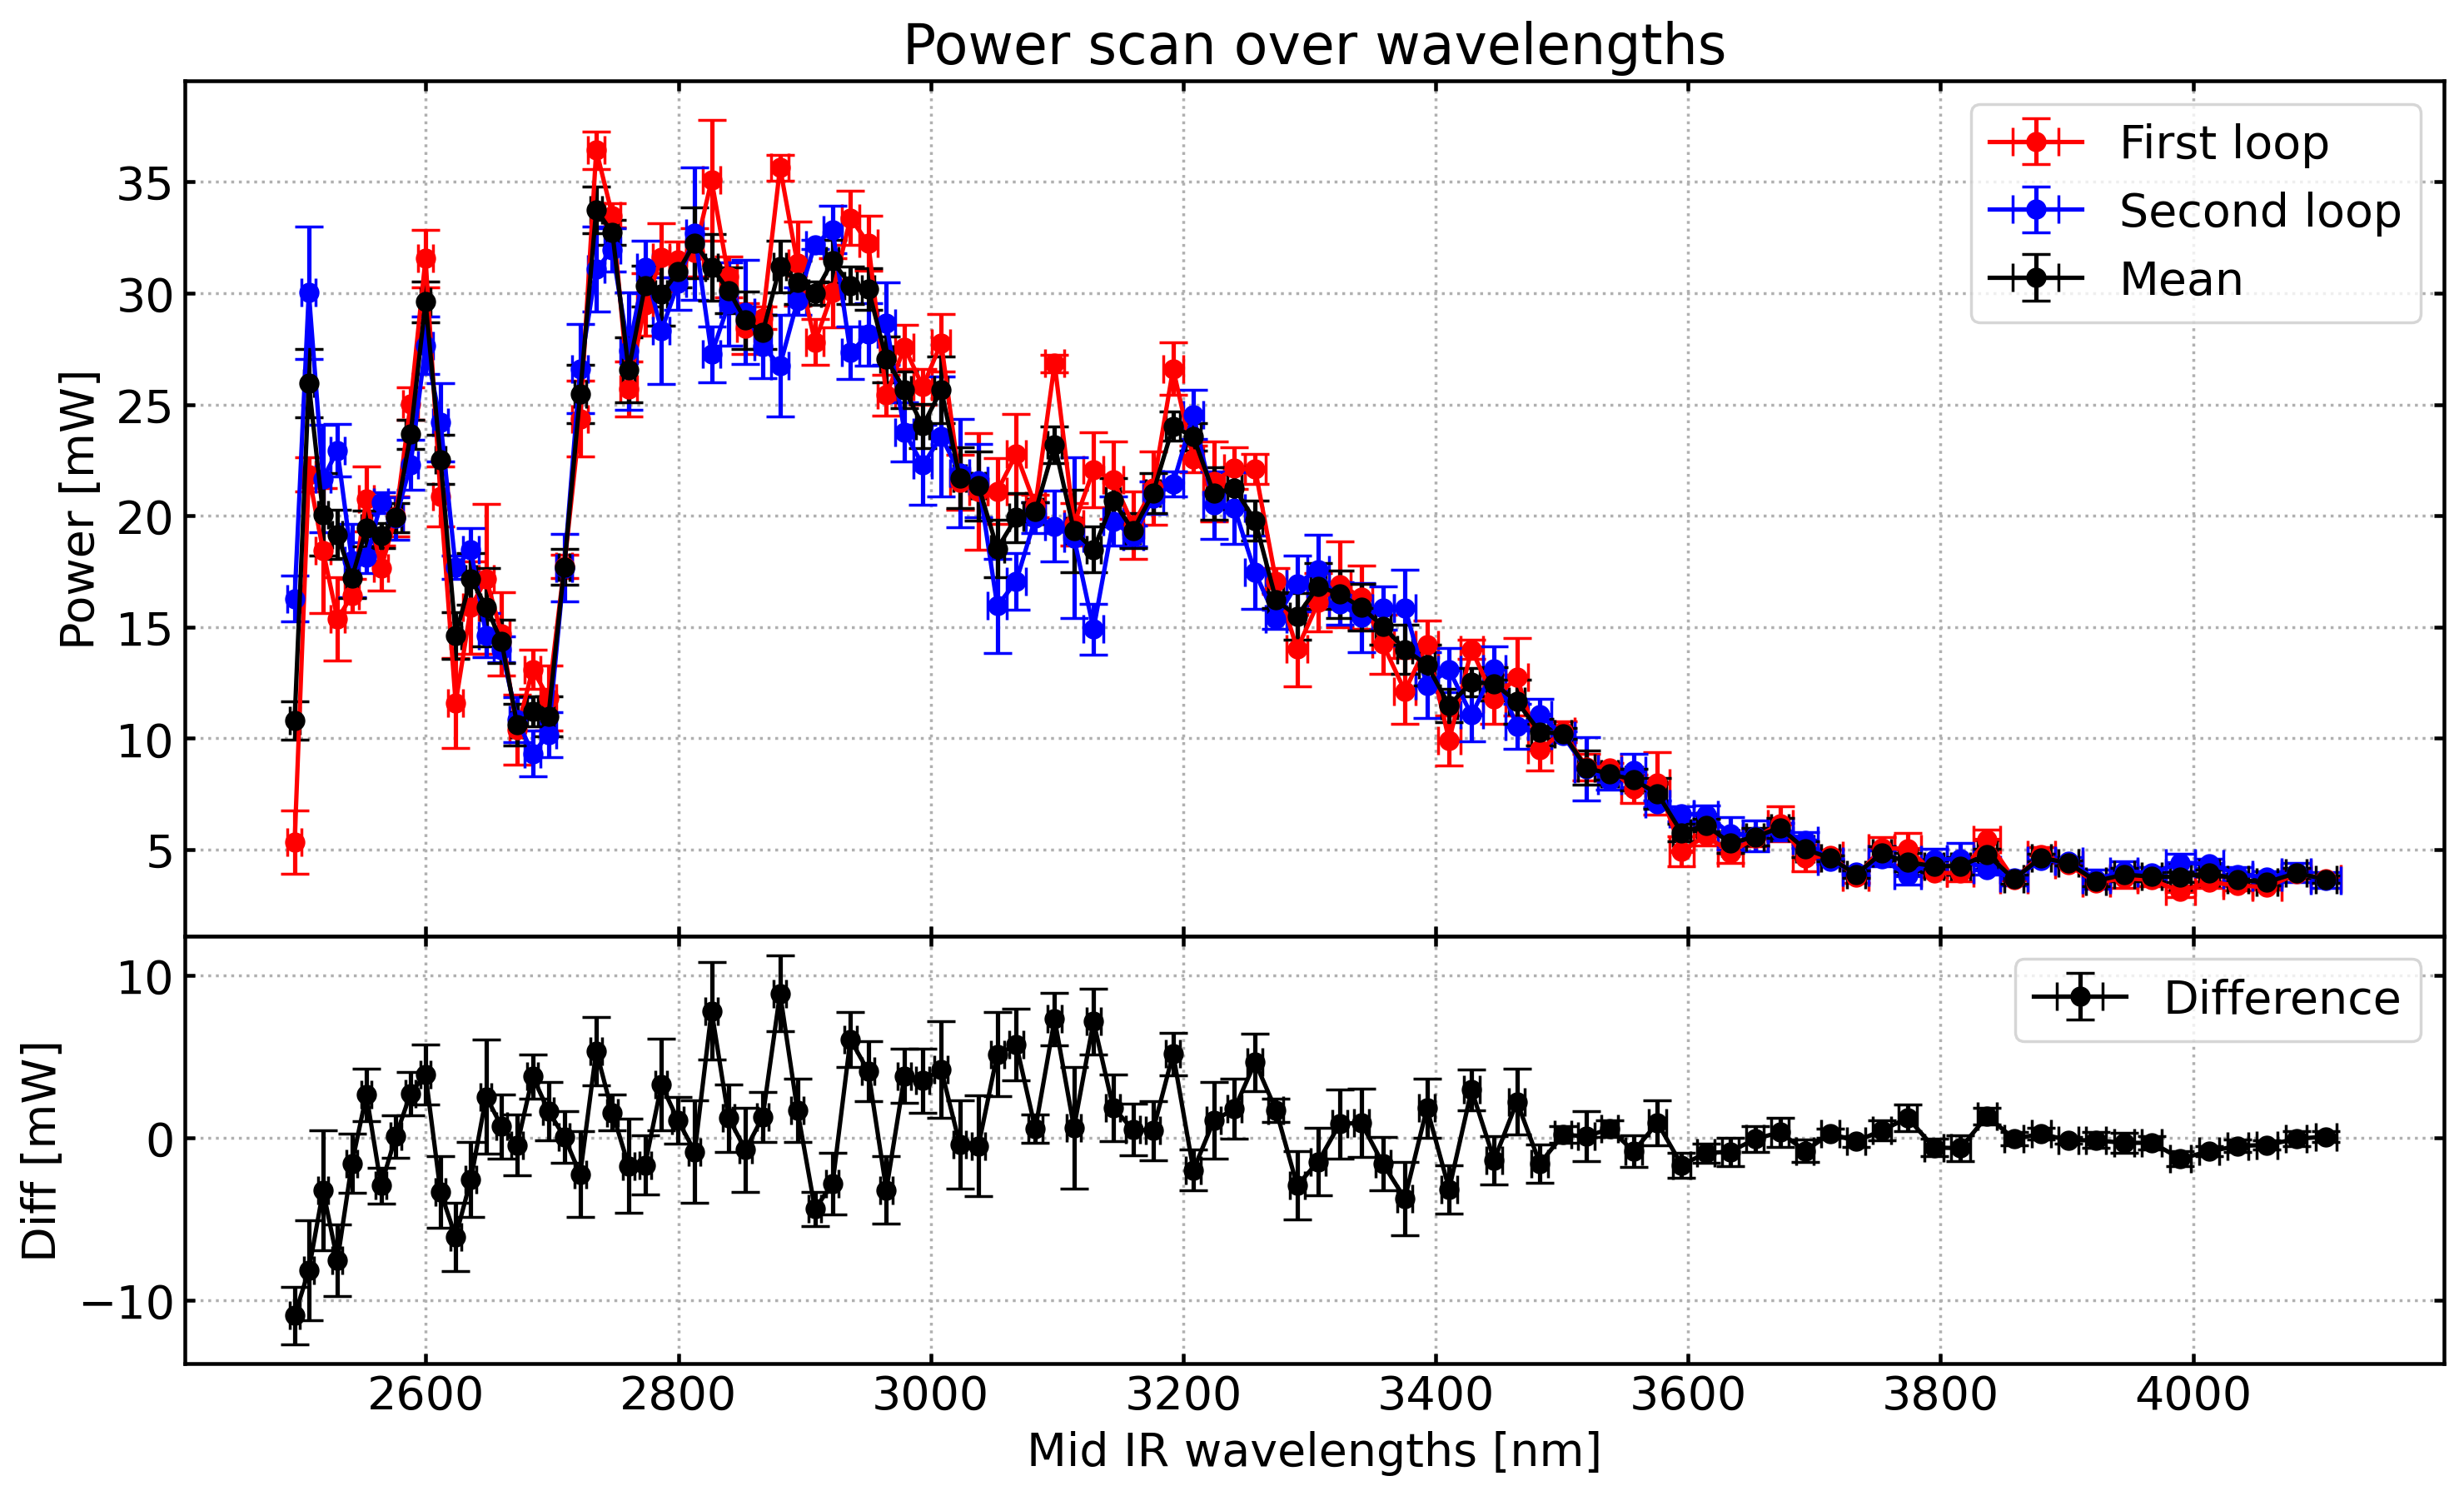

In [257]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, 
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})



ax = axs[0]
df = df_tot.query("index < 100").copy()
xs = [x.n for x in df["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df["MonWavelengthMidIR"]]
ys = [y.n for y in df["Power"]]
ys_unc = [y.s for y in df["Power"]]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='First loop', 
            color='red', capsize=5)

df = df_tot.query("index >= 100").copy()
xs = [x.n for x in df["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df["MonWavelengthMidIR"]]
ys = [y.n for y in df["Power"]]
ys_unc = [y.s for y in df["Power"]]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='Second loop', 
            color='blue', capsize=5)

ax.set_ylabel("Power [mW]")
ax.set_title("Power scan over wavelengths")

xs = [x.n for x in mean_wavelength]
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in mean_power]
ys_unc = [y.s for y in mean_power]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Mean', color='black', capsize=5)

ax.legend()

ax = axs[1]
ys = [y.n for y in difference_power]
ys_unc = [y.s for y in difference_power]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='Difference', 
            color='black', capsize=5)

ax.set_ylabel("Diff [mW]")
ax.set_xlabel("Mid IR wavelengths [nm]")
ax.legend()

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Skal omdannes til antal photoner 

In [258]:
def energy_to_photons(energy_per_wavelength, wavelengths):
    """
    Convert energy per wavelength to number of photons per wavelength.
    
    Parameters:
    - energy_per_wavelength: Array of energies at each wavelength (Joules).
    - wavelengths: Array of wavelengths (in nm).
    
    Returns:
    - photons_per_wavelength: Array of number of photons per wavelength.
    """
    photon_energy = c.h.value * c.c.value / (wavelengths * 1e-9)
    photons_per_wavelength = energy_per_wavelength / photon_energy
    return photons_per_wavelength


In [259]:
water_vib_wavelengths = [1/val * 1e7 for val in [3657, 1595, 3756] ] # first list in 1/cm the final is nm
water_vib_naming = [r"A_$1$ sym stretch", r"A_$1$ bend", r"B_$1$ anti stretch"]
water_vib_energies = [c.h.value * c.c.value / (w * 1e-9) * joule_to_ev for w in water_vib_wavelengths]
water_colors = ["yellow", "red", "blue"]

In [260]:
max_wavelength = max([i.n for i in df_tot["MonWavelengthMidIR"]])
min_wavelength = min([i.n for i in df_tot["MonWavelengthMidIR"]])

joule_to_ev = 6.24150907 * 1e18
# in nm
wavelengths_nir = np.linspace(715, 880, 10000)
wavelengths = np.array([wavelength_idler(x).n for x in wavelengths_nir])
# in eV
photon_energies = c.h.value * c.c.value / (wavelengths * 1e-9) * joule_to_ev 

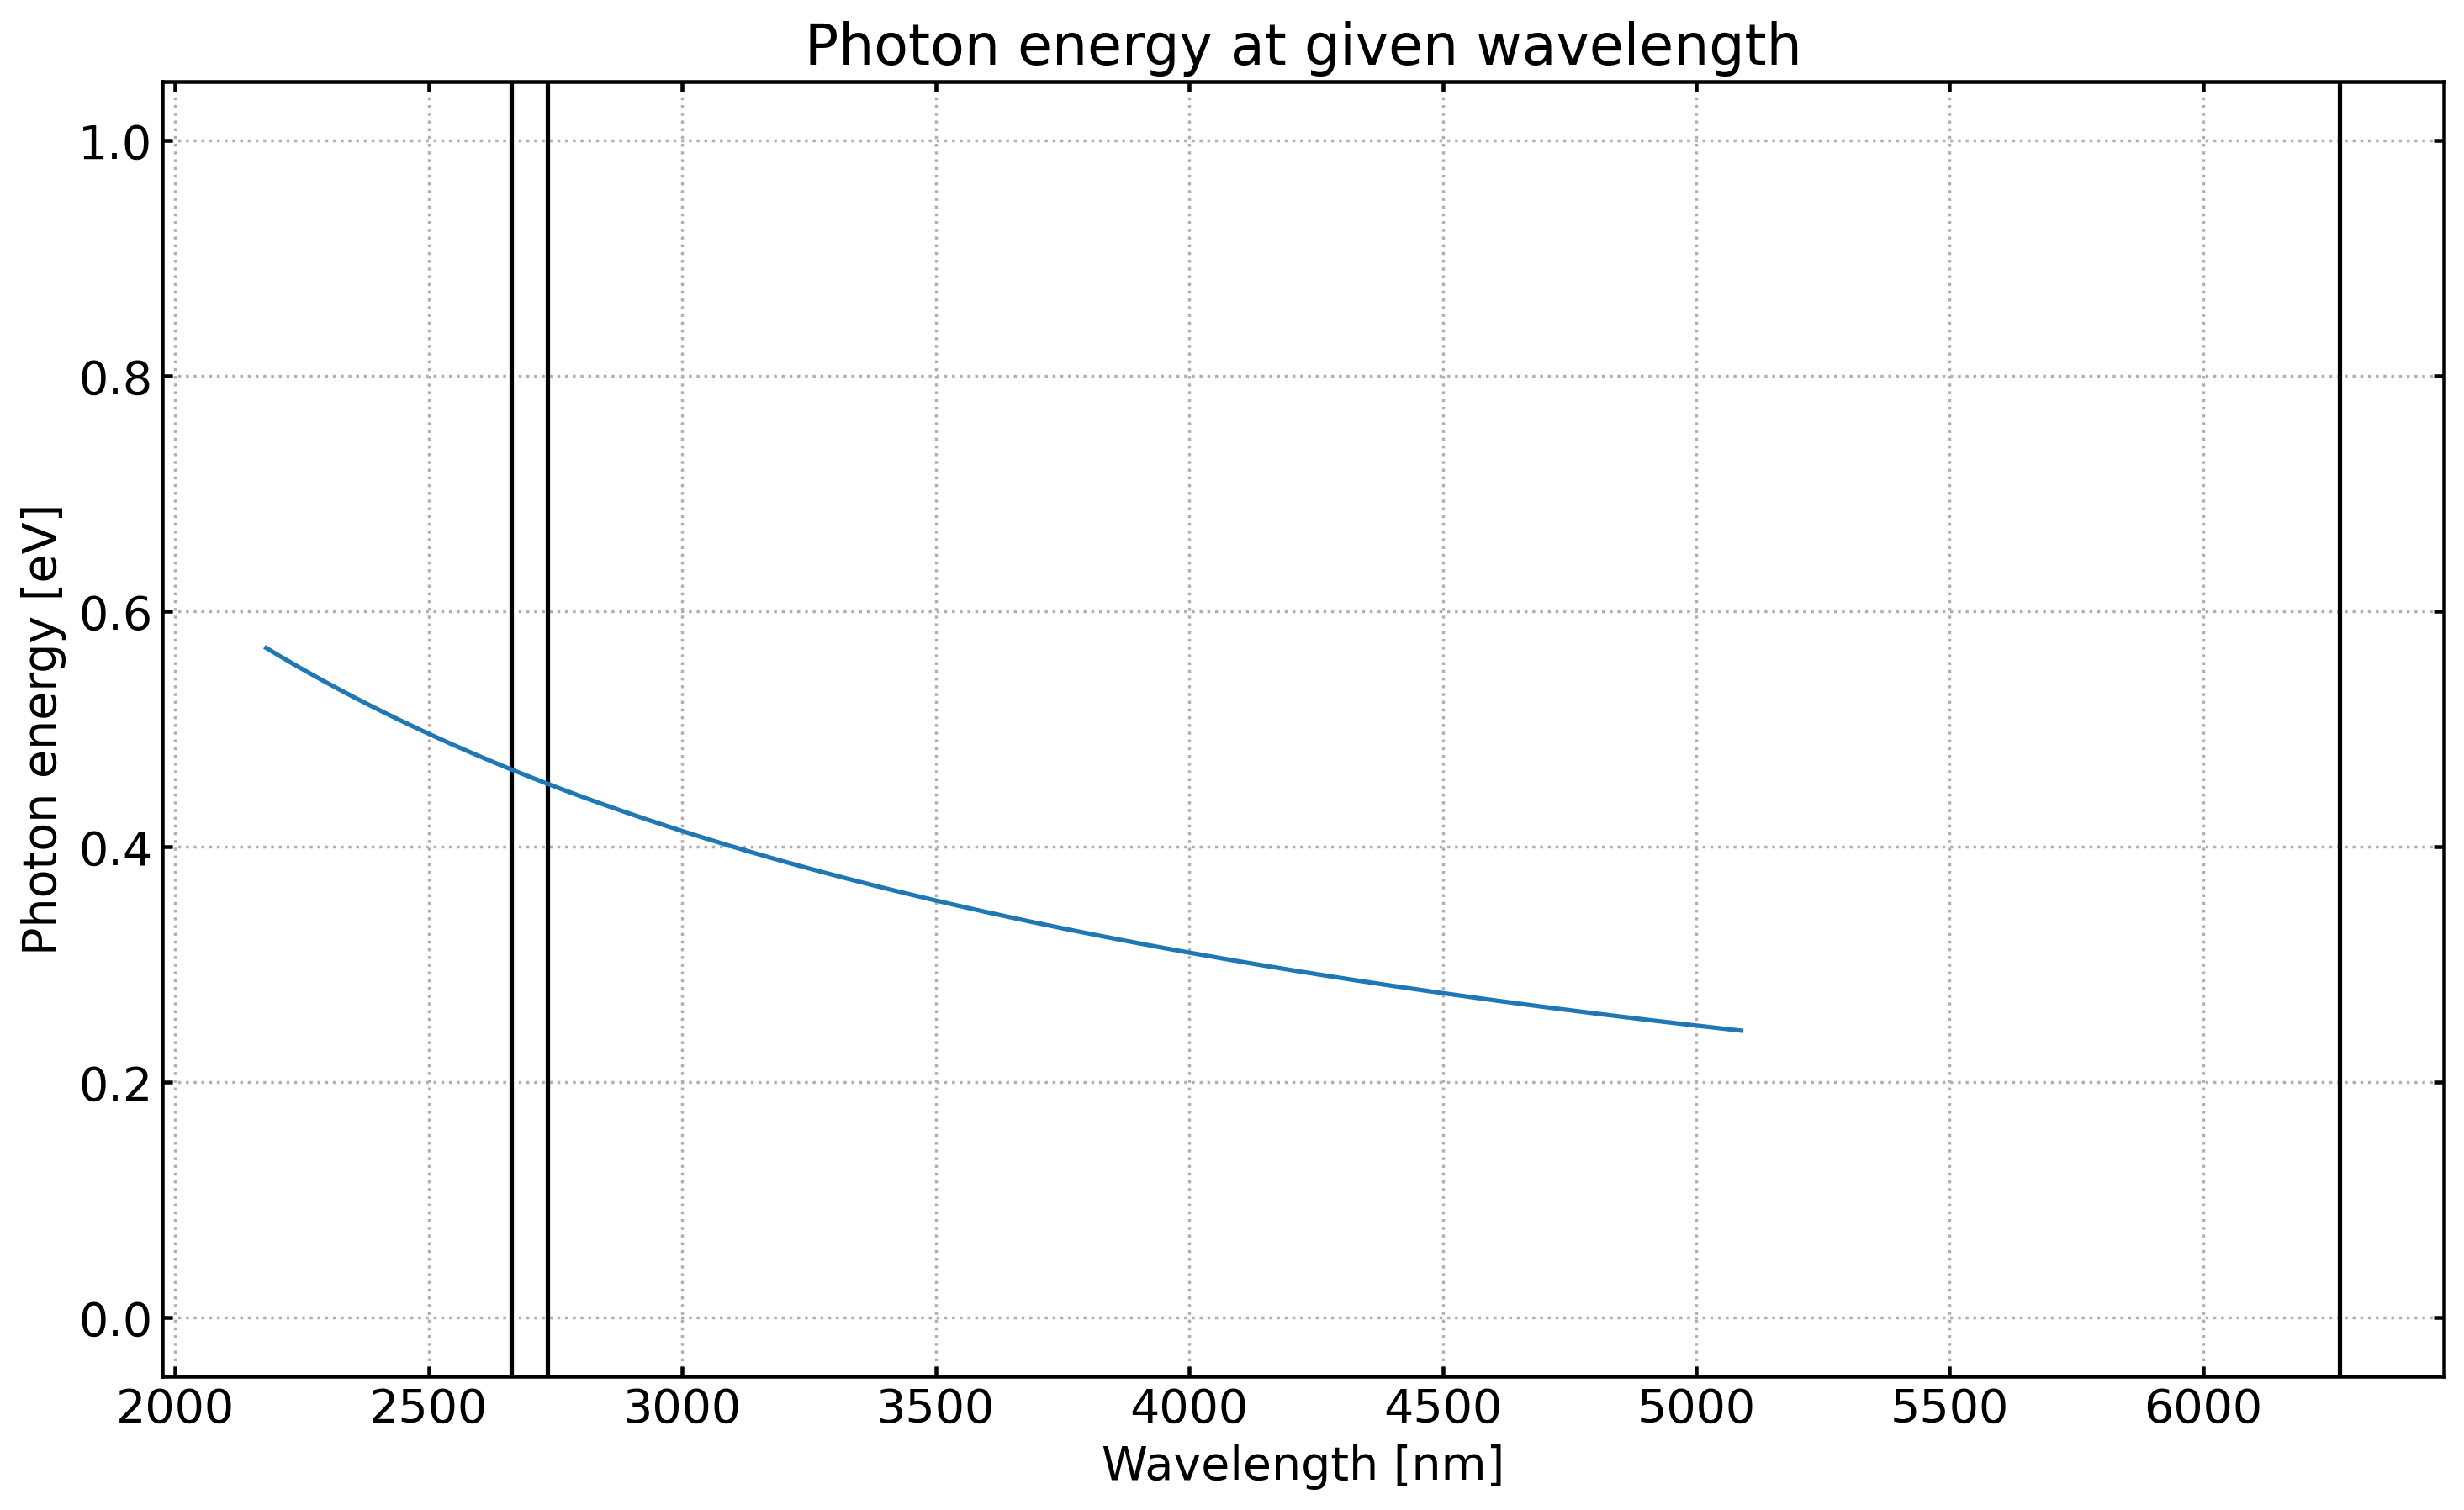

(2179.828080229226, 5088.695652173913)

In [261]:
for i in range(len(water_vib_wavelengths)):
    plt.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 1),
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", color="black")
plt.plot(wavelengths, photon_energies)
plt.ylabel("Photon energy [eV]")
plt.xlabel("Wavelength [nm]")
plt.title("Photon energy at given wavelength")
plt.show()
wavelengths[0], wavelengths[-1]

In [262]:
df_tot["Power in J"] = df_tot["Power"].values / 10 / 1000
df_tot["N_Photons"] = df_tot.apply(
    lambda row: energy_to_photons(
        row["Power in J"]                            
        # Dividing with 10 to get this to be in J, since the frequency of the laser is 10 Hz
        , row["MonWavelengthMidIR"]
    ), axis=1
)

difference_photon = (df_tot.query("index < 100")["N_Photons"].values - 
                         df_tot.query("index >= 100")["N_Photons"].values)

mean_photon = (df_tot.query("index < 100")["N_Photons"].values + 
                         df_tot.query("index >= 100")["N_Photons"].values) / 2


In [263]:
df_tot["Mon_value"][0], df_tot["Mon_value"][199]

(746.00005, 843.99998)

In [264]:
mean_wavelengths_near = (df_tot.query("index < 100")["Mon_value"].values + 
                         df_tot.query("index >= 100")["Mon_value"].values) / 2

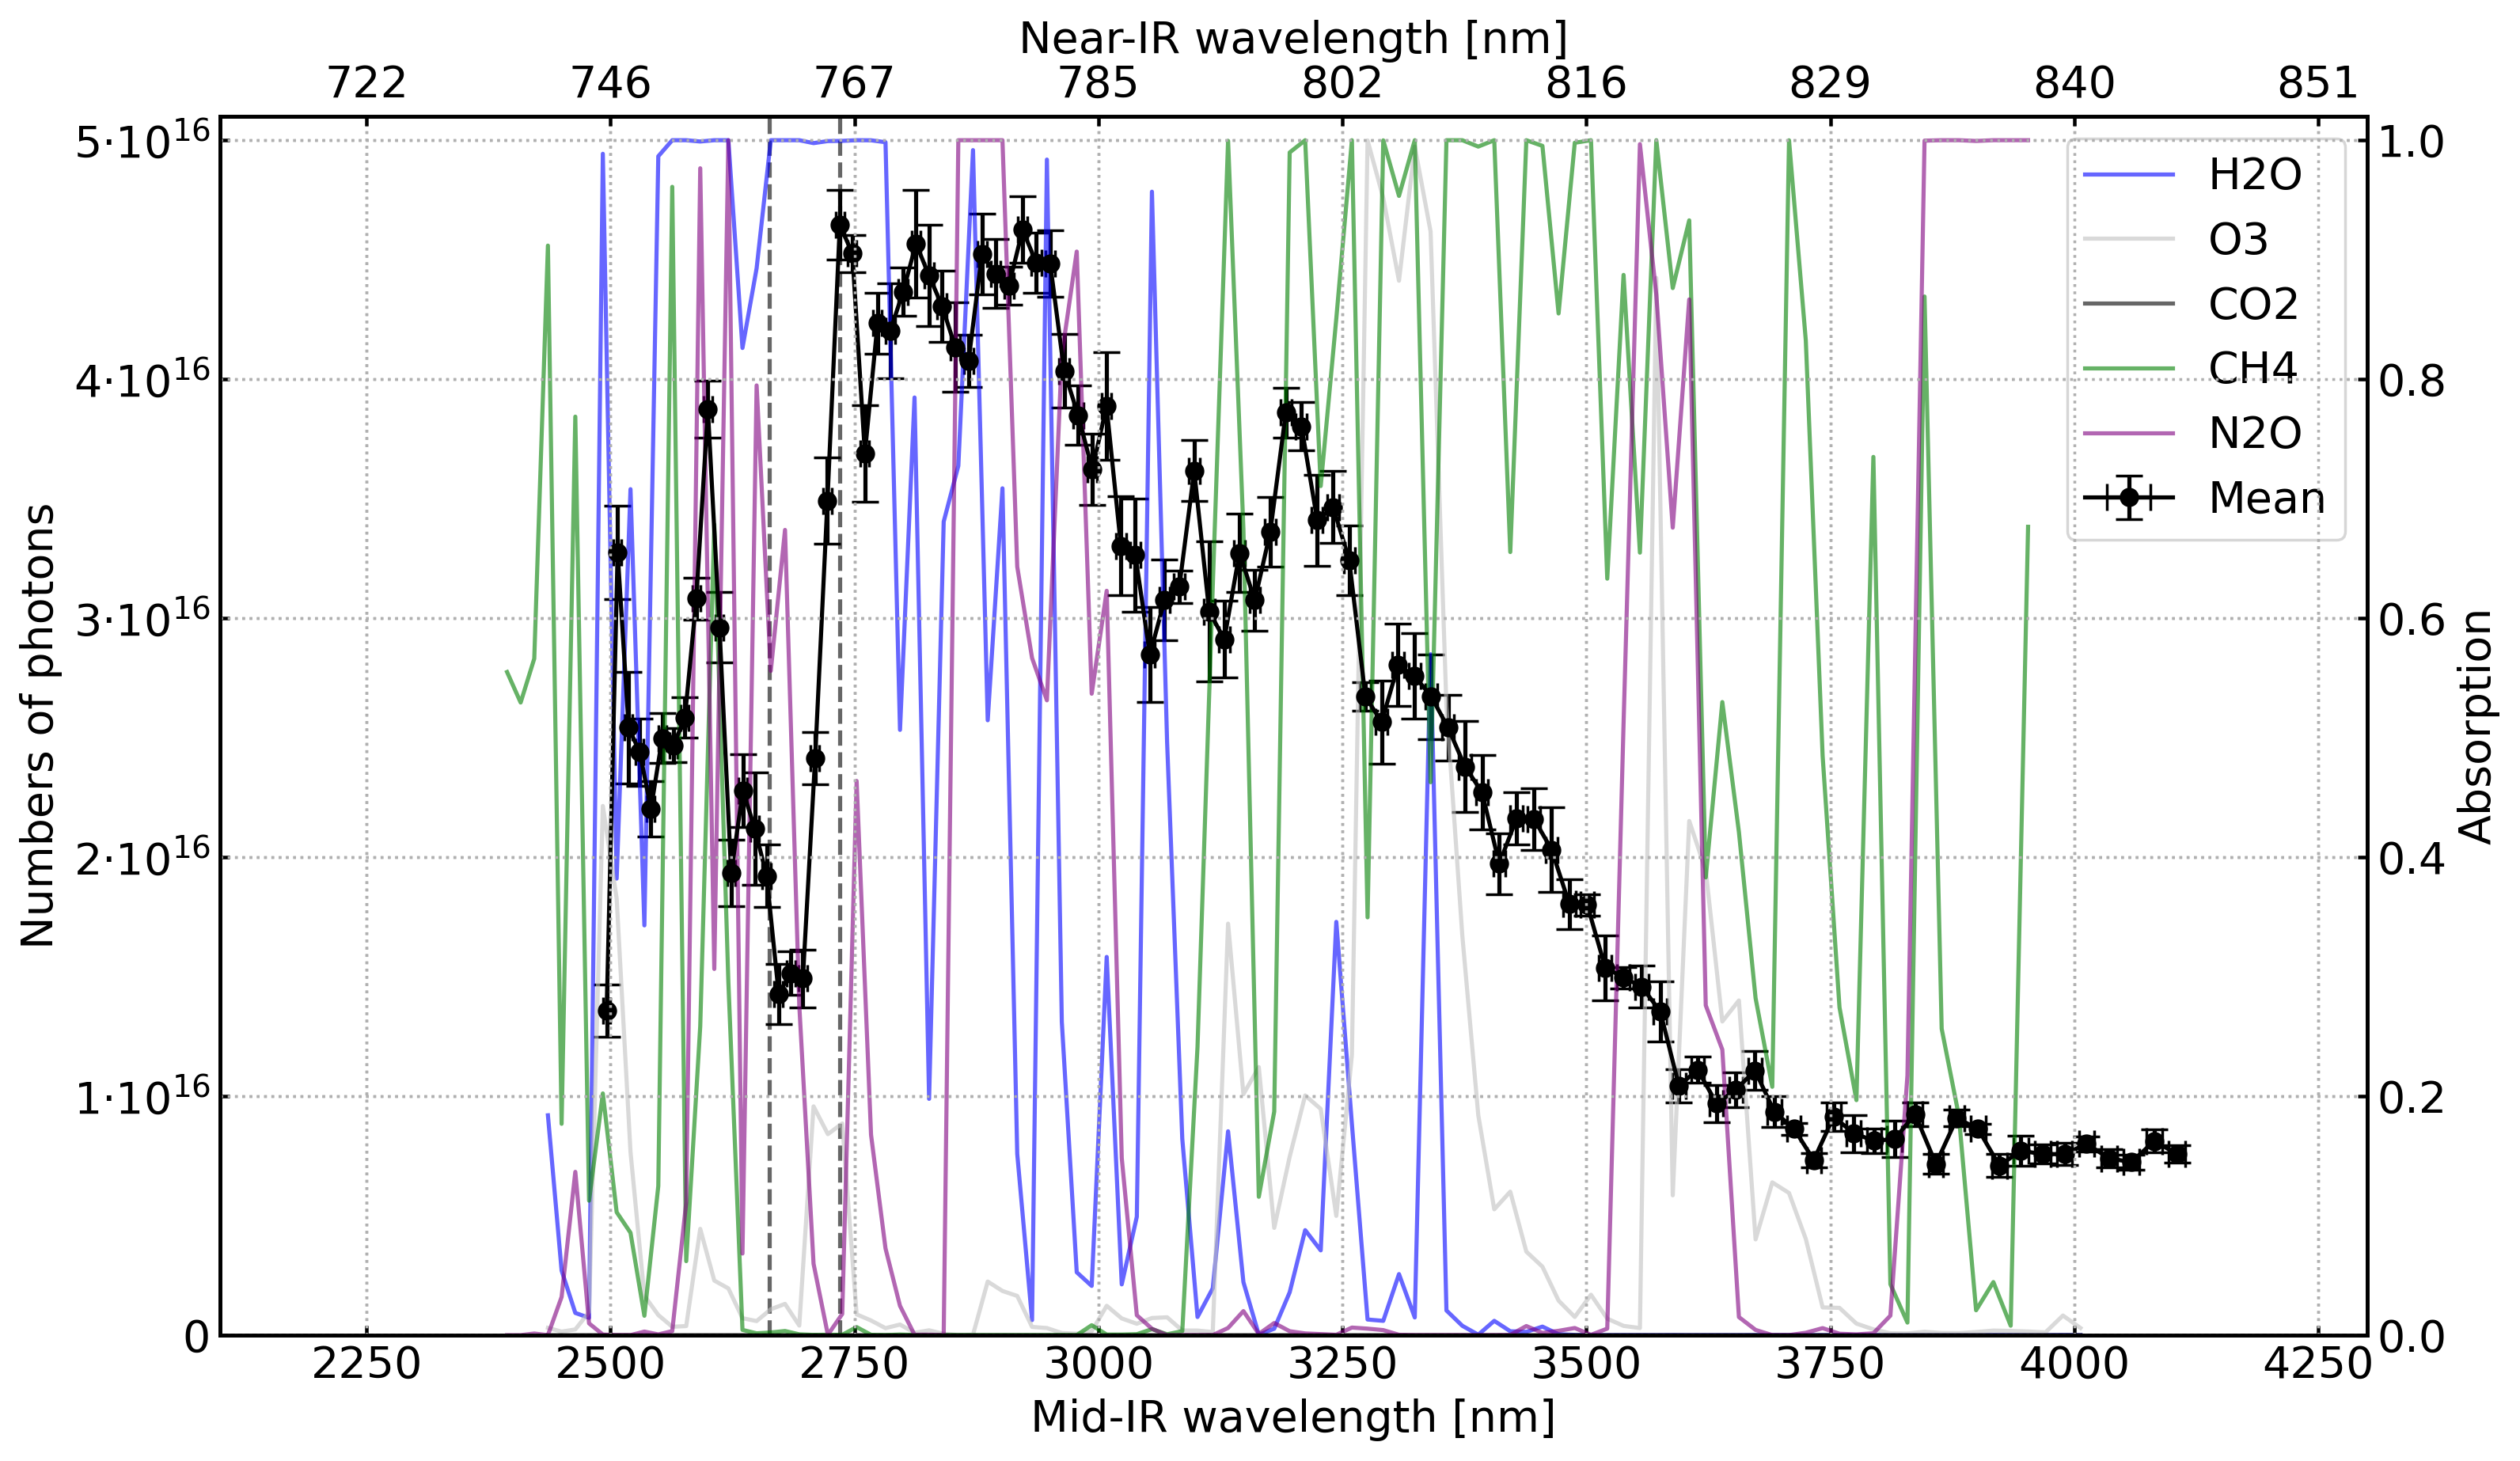

In [323]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
                        #gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})
line = True
fill = False
for i in range(len(water_vib_wavelengths)):
    if i == 1:
        continue
    if line:
        ax.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 5e16),
              # label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color="black", alpha=0.6, linestyle="--"
                    )
    if fill:
        ax.fill_betweenx([0, 5e16], water_vib_wavelengths[i] - 10, water_vib_wavelengths[i] + 10,
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color=water_colors[i], alpha=0.6
                    )

ax.set_ylabel("Numbers of photons")
ax.set_xlabel("Mid-IR wavelength [nm]")
# ax.set_title("The amount of photons at given wavelengths")

xs = [x.n for x in mean_wavelength]
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in mean_photon]
ys_unc = [y.s for y in mean_photon]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Mean', color='Black', capsize=5)


ax.set_ylim(0, 5.1e16)
ax.set_xlim(2100, 4300)


ax2 = ax.twiny()

ax2.set_xticks(ax.get_xticks()) 
ax2.set_xlim(2100, 4300)
ax2.set_xticklabels([f"{round(mid_ir_to_near_ir(x_tick), 0):.0f}" for x_tick in ax.get_xticks()])
ax2.set_xlabel(f'Near-IR wavelength [nm]', color='Black')
ax2.tick_params(axis='x', labelcolor='Black')

ax2 = ax.twinx()

ax2.set_yticks(ax.get_yticks()) 
ax2.set_ylim(0, 5.1e16)
ax2.set_yticklabels([f"{y_tick:.1f}" for y_tick in np.linspace(0, 1.2, len(ax.get_yticks()))])
ax2.set_ylabel('Absorption', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)
ax.set_yticks(np.arange(0, 6e16, 1e16))
ax.set_yticklabels([f'{int(tick/1e16)}' + r'$\cdot 10^{16}$' if tick!=0 else '0' for tick in ax.get_yticks()])

ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * 5e16, label="H2O", alpha=0.6, color="Blue")
ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * 5e16, label="O3", alpha=0.6, color="silver")
ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * 5e16, label="CO2", alpha=0.6, color="black")
ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * 5e16, label="CH4", alpha=0.6, color="green")
ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * 5e16, label="N2O", alpha=0.6, color="Purple")

ax.legend()
plt.show()


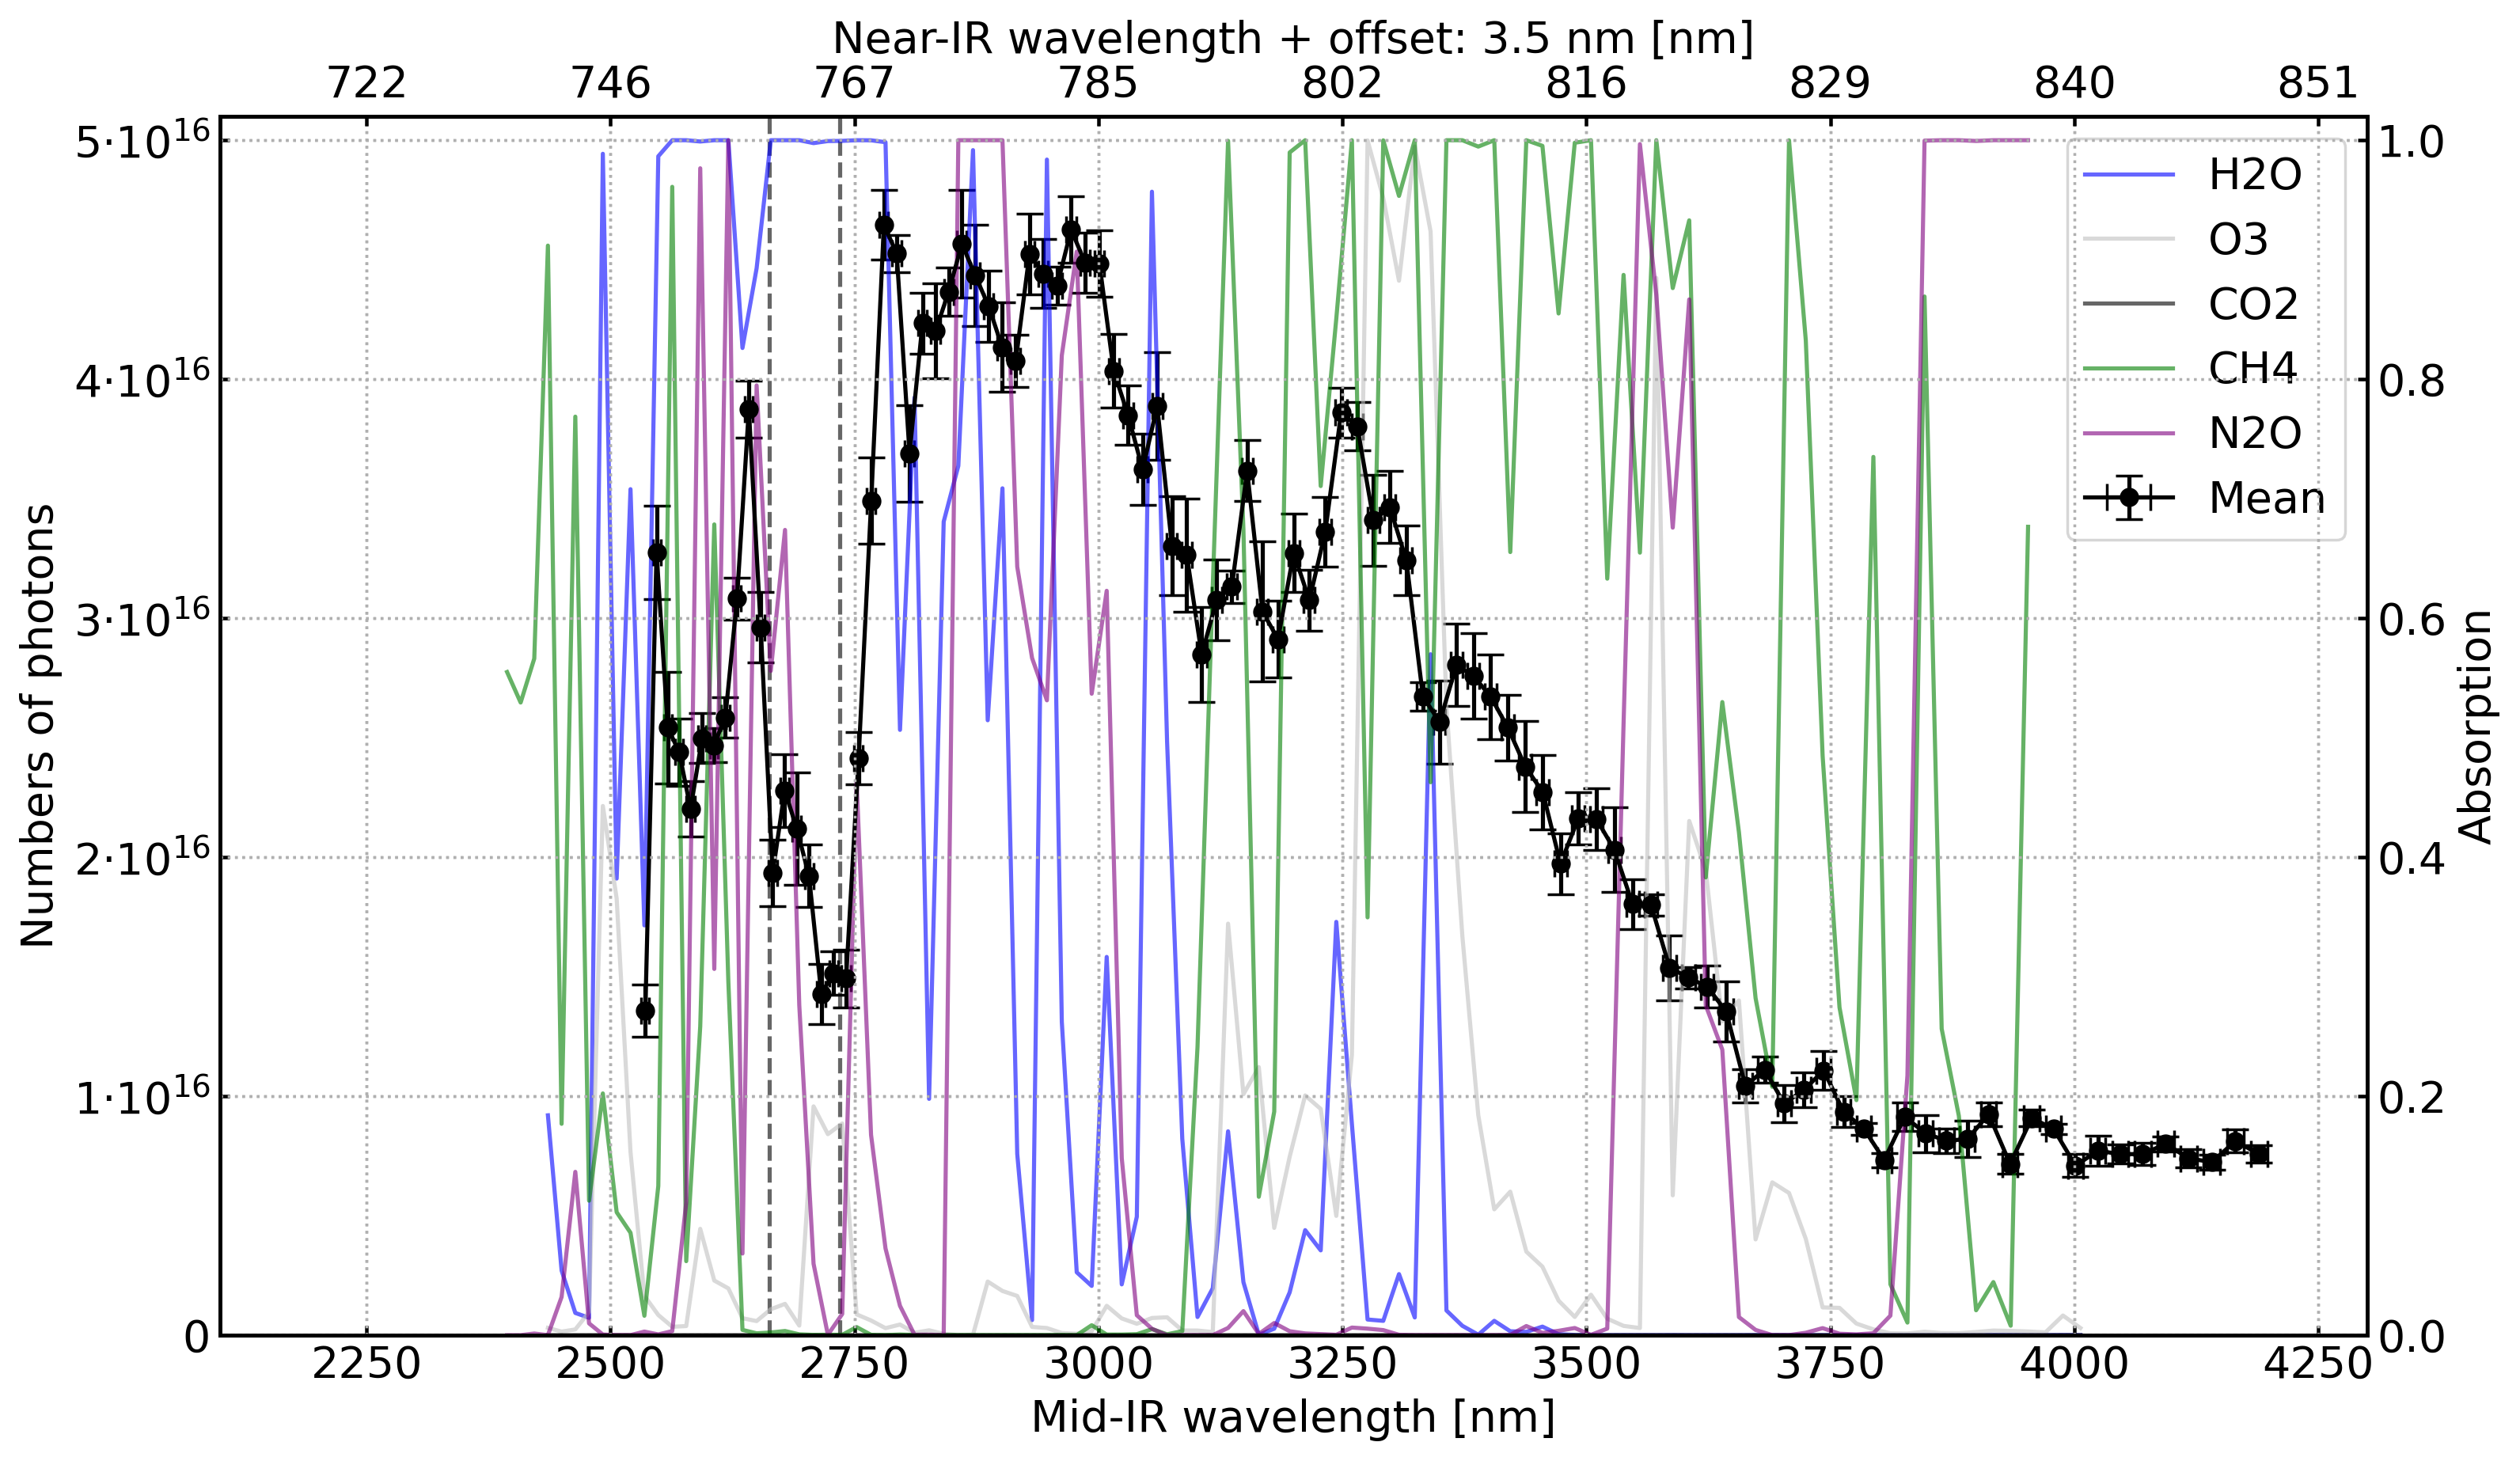

In [321]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
                        #gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})
line = True
fill = False
for i in range(len(water_vib_wavelengths)):
    if i == 1:
        continue
    if line:
        ax.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 5e16),
              # label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color="black", alpha=0.6, linestyle="--"
                    )
    if fill:
        ax.fill_betweenx([0, 5e16], water_vib_wavelengths[i] - 10, water_vib_wavelengths[i] + 10,
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color=water_colors[i], alpha=0.6
                    )

ax.set_ylabel("Numbers of photons")
ax.set_xlabel("Mid-IR wavelength [nm]")
# ax.set_title("The amount of photons at given wavelengths")

xs = [x.n for x in mean_wavelength_offset]
xs_unc = [x.s for x in mean_wavelength_offset]
ys = [y.n for y in mean_photon]
ys_unc = [y.s for y in mean_photon]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data', color='Black', capsize=5)


ax.set_ylim(0, 5.1e16)
ax.set_xlim(2100, 4300)


ax2 = ax.twiny()

ax2.set_xticks(ax.get_xticks()) 
ax2.set_xlim(2100, 4300)
ax2.set_xticklabels([f"{round(mid_ir_to_near_ir(x_tick), 0):.0f}" for x_tick in ax.get_xticks()])
ax2.set_xlabel(f'Near-IR wavelength + offset: {near_ir_offset} nm [nm]', color='Black')
ax2.tick_params(axis='x', labelcolor='Black')

ax2 = ax.twinx()

ax2.set_yticks(ax.get_yticks()) 
ax2.set_ylim(0, 5.1e16)
ax2.set_yticklabels([f"{y_tick:.1f}" for y_tick in np.linspace(0, 1.2, len(ax.get_yticks()))])
ax2.set_ylabel('Absorption', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)
ax.set_yticks(np.arange(0, 6e16, 1e16))
ax.set_yticklabels([f'{int(tick/1e16)}' + r'$\cdot 10^{16}$' if tick!=0 else '0' for tick in ax.get_yticks()])

ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * 5e16, label="H2O", alpha=0.6, color="Blue")
ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * 5e16, label="O3", alpha=0.6, color="silver")
ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * 5e16, label="CO2", alpha=0.6, color="black")
ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * 5e16, label="CH4", alpha=0.6, color="green")
ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * 5e16, label="N2O", alpha=0.6, color="Purple")

ax.legend()
plt.show()


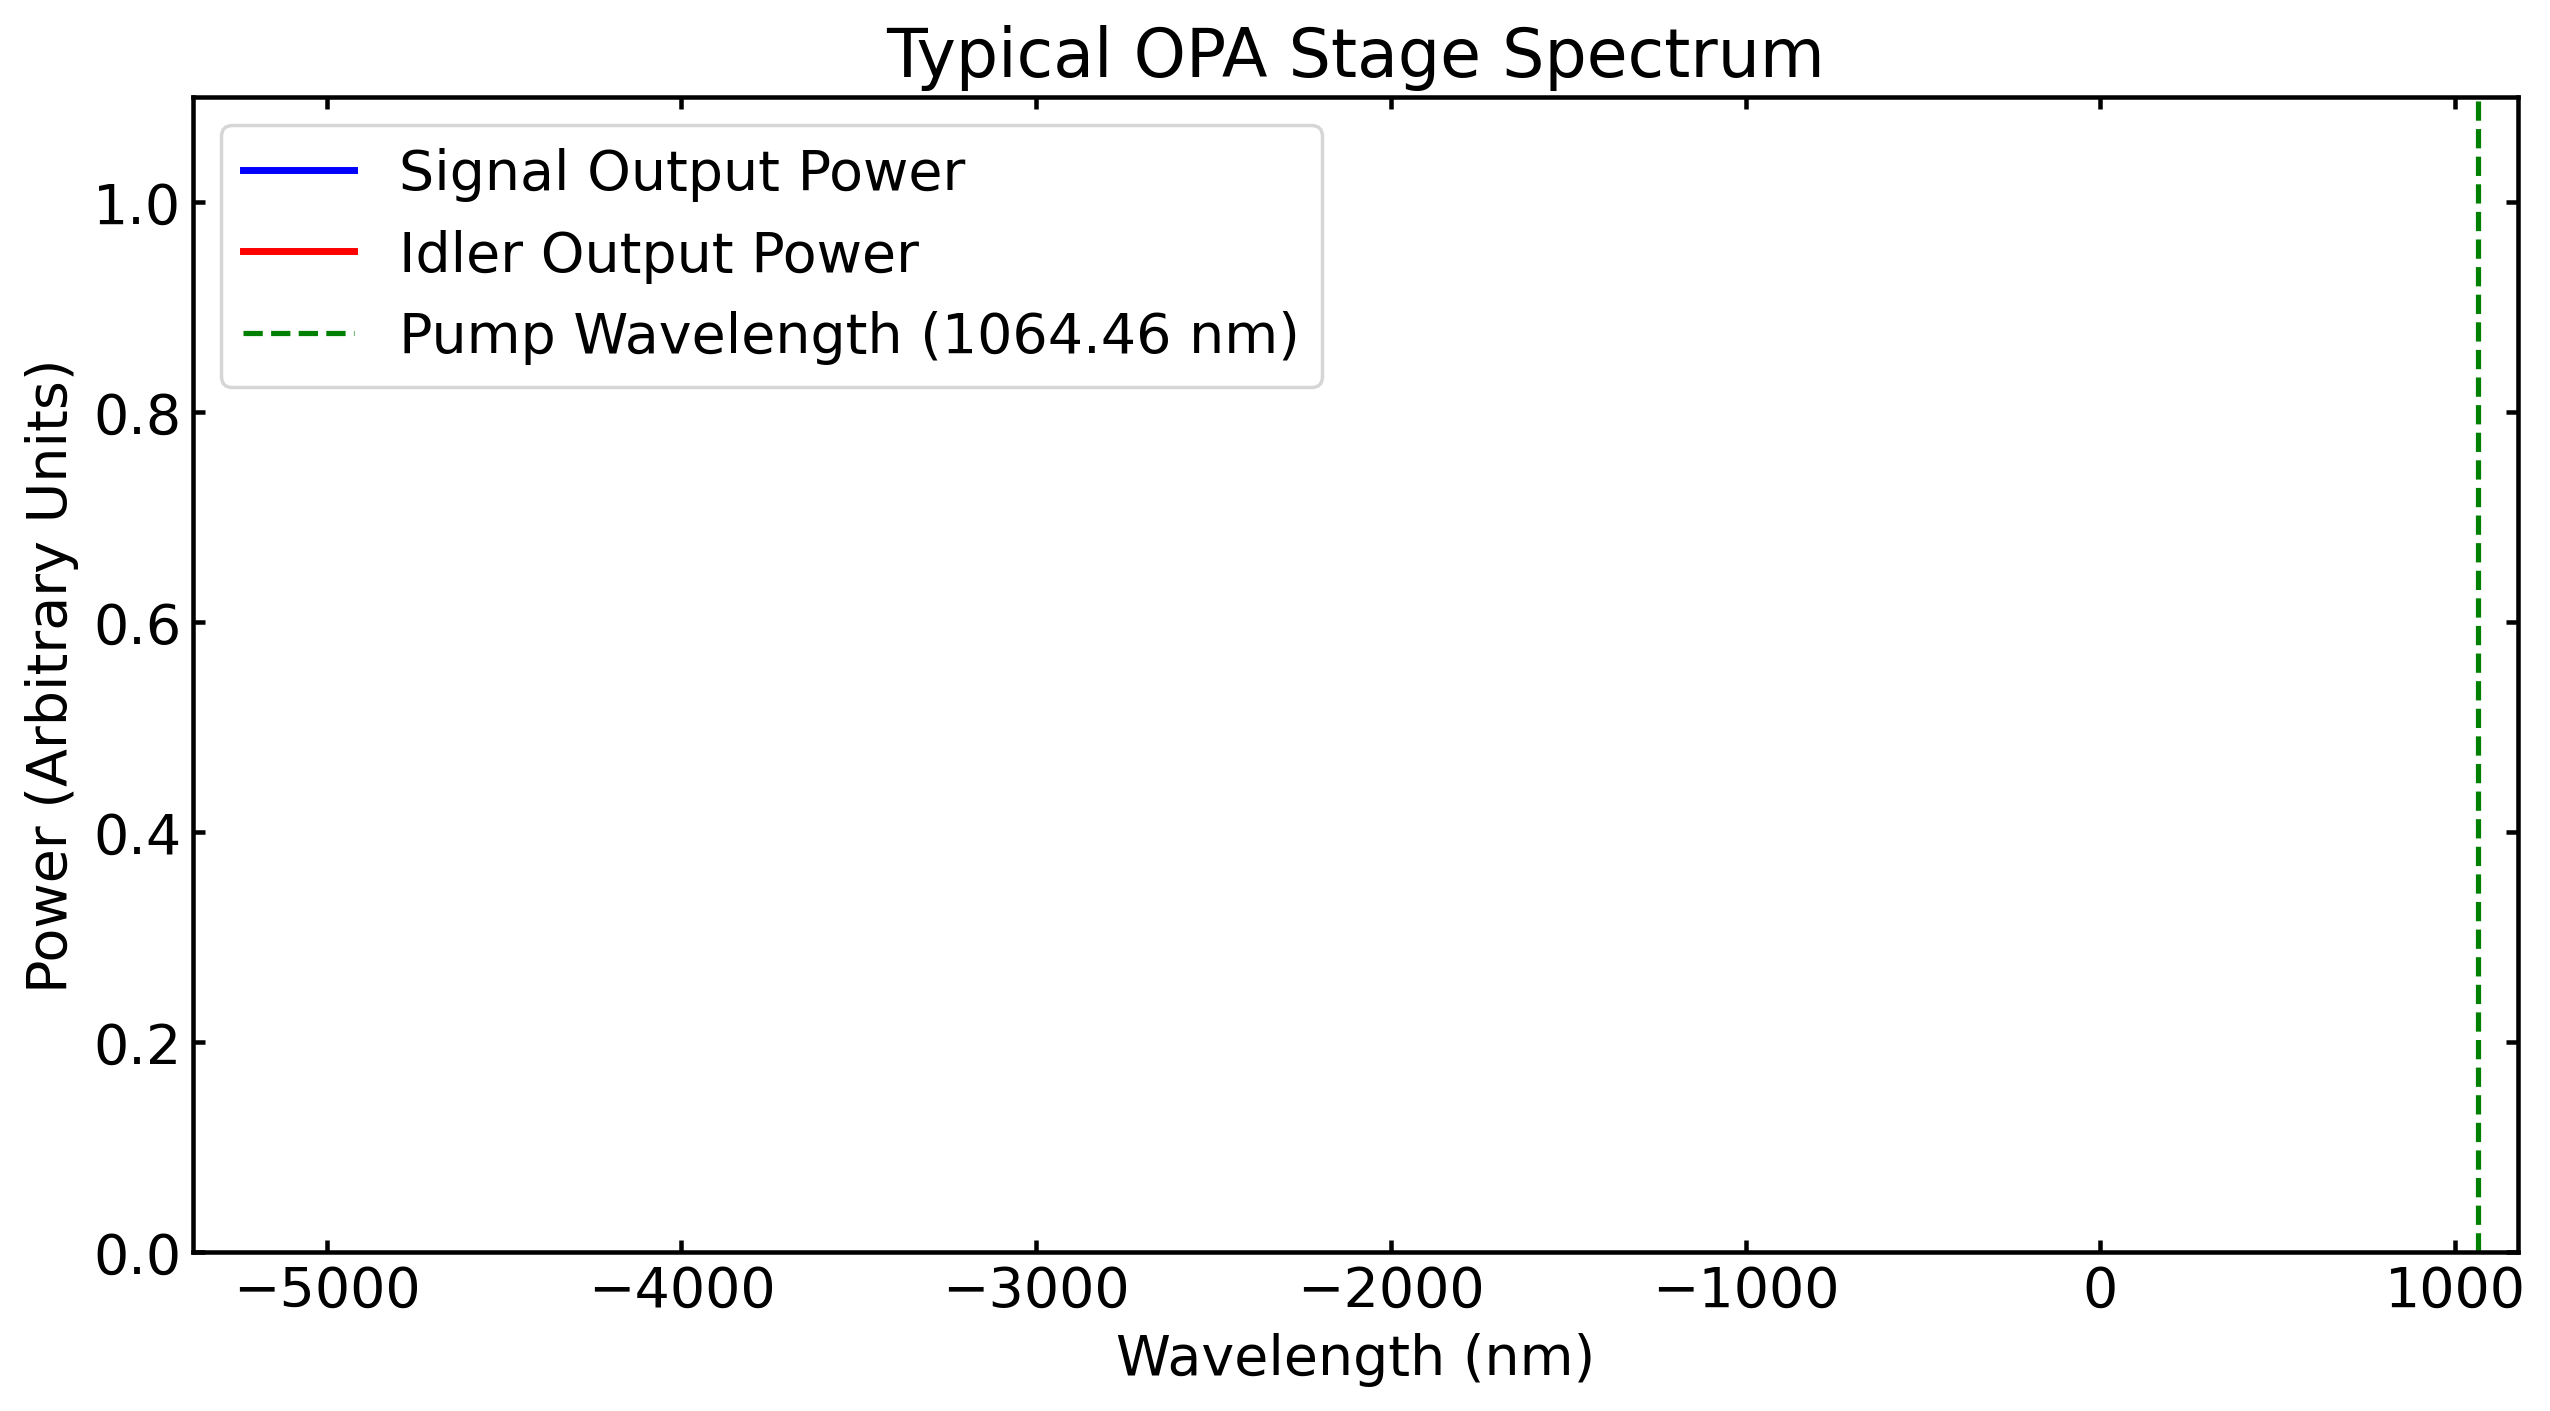

In [327]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
signal_wavelength = 1064.46  # Pump wavelength in nm
pump_wavelengths = np.linspace(712, 880, 1000)  # Tunable signal range from 712 nm to 880 nm

# Calculate idler wavelengths using the conservation of energy relation
idler_wavelengths = 1 / (1/pump_wavelength - 1/signal_wavelengths)

# Define OPA spectrum characteristics
def opa_spectrum(signal_wavelength):
    # Assume a Gaussian profile for the signal output
    width_signal = 5  # Width of the Gaussian for the signal
    signal_peak = np.exp(-((signal_wavelength - signal_wavelengths)**2) / (width_signal**2))

    # Assume a Gaussian profile for the idler output
    width_idler = 10  # Width of the Gaussian for the idler
    idler_peak = np.exp(-((idler_wavelengths - (1/(1/pump_wavelength - 1/signal_wavelength)))**2) / (width_idler**2))

    return signal_peak, idler_peak

# Calculate power spectrum
power_signal = np.zeros_like(signal_wavelengths)
power_idler = np.zeros_like(idler_wavelengths)

for i, wavelength in enumerate(signal_wavelengths):
    signal_peak, idler_peak = opa_spectrum(wavelength)
    power_signal += signal_peak
    power_idler += idler_peak

# Plotting
plt.figure(figsize=(12, 6))

# Plot signal power
plt.plot(signal_wavelengths, power_signal, color='blue', linewidth=2, label='Signal Output Power')

# Plot idler power on the same wavelength range
plt.plot(idler_wavelengths, power_idler, color='red', linewidth=2, label='Idler Output Power')

# Mark the pump wavelength
plt.axvline(x=pump_wavelength, color='green', linestyle='--', label='Pump Wavelength (1064.46 nm)', linewidth=1.5)

# Labels and title
plt.title('Typical OPA Stage Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power (Arbitrary Units)')
plt.ylim(0, 1.1)  # Set y-axis limit for clarity
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [44]:
from hapi import *

In [45]:
db_begin('data')

Using data



In [225]:
def get_absorption_data(molecule: str):
    
    nu, coef = absorptionCoefficient_Lorentz(SourceTables=molecule, 
                                             Diluent={'air': 1.0}, 
                                             Environment = {'p': 1.0,'T': 296.0}, 
                                             HITRAN_units=False,
                                             WavenumberGrid=xs,
                                            )
    nu_new, absorp = absorptionSpectrum(nu, coef, # The Temperature here needs to be the same as in the one before
                                    Environment={'T': 296.0, 'l': 100.0},
                                   )

    assert len(nu_new) == len(absorp), "Mismatch between wavenumber grid and absorption data length!"
    
    return nu_new, absorp

In [208]:
start_wavenumber = int(wavelength_to_wavenumber(4200))
end_wavenumber = int(wavelength_to_wavenumber(2100))

In [324]:
# fetch('H2O',1,1, start_wavenumber, end_wavenumber)
# fetch('CO2',2,1, start_wavenumber, end_wavenumber)
# fetch('O3',3,1, start_wavenumber, end_wavenumber)
# fetch('O2',7,1, start_wavenumber, end_wavenumber) Missing this one, Update there is no data for this range for O2
# fetch('CH4',6,1, start_wavenumber, end_wavenumber)
# fetch('N2O',4,1, start_wavenumber, end_wavenumber)

In [285]:
# describeTable('N2O')

In [ ]:
# describeTable('CH4')

In [180]:
# describeTable('O3')

In [156]:
# describeTable('H2O')

In [157]:
# describeTable('CO2')

In [287]:
nu_n2o, absorp_n2o = get_absorption_data("N2O")

{'air': 1.0}
1.633943 seconds elapsed for abscoef; nlines = 14666


In [281]:
nu_ch4, absorp_ch4 = get_absorption_data("CH4")

{'air': 1.0}
9.110410 seconds elapsed for abscoef; nlines = 111966


In [226]:
nu_h2o, absorp_h2o = get_absorption_data("H2O")

{'air': 1.0}
2.762332 seconds elapsed for abscoef; nlines = 23942


In [234]:
nu_o3, absorb_o3 = get_absorption_data("O3")

{'air': 1.0}
6.212183 seconds elapsed for abscoef; nlines = 96632


In [235]:
nu_co2, absorb_co2 = get_absorption_data("CO2")

{'air': 1.0}
0.039715 seconds elapsed for abscoef; nlines = 335


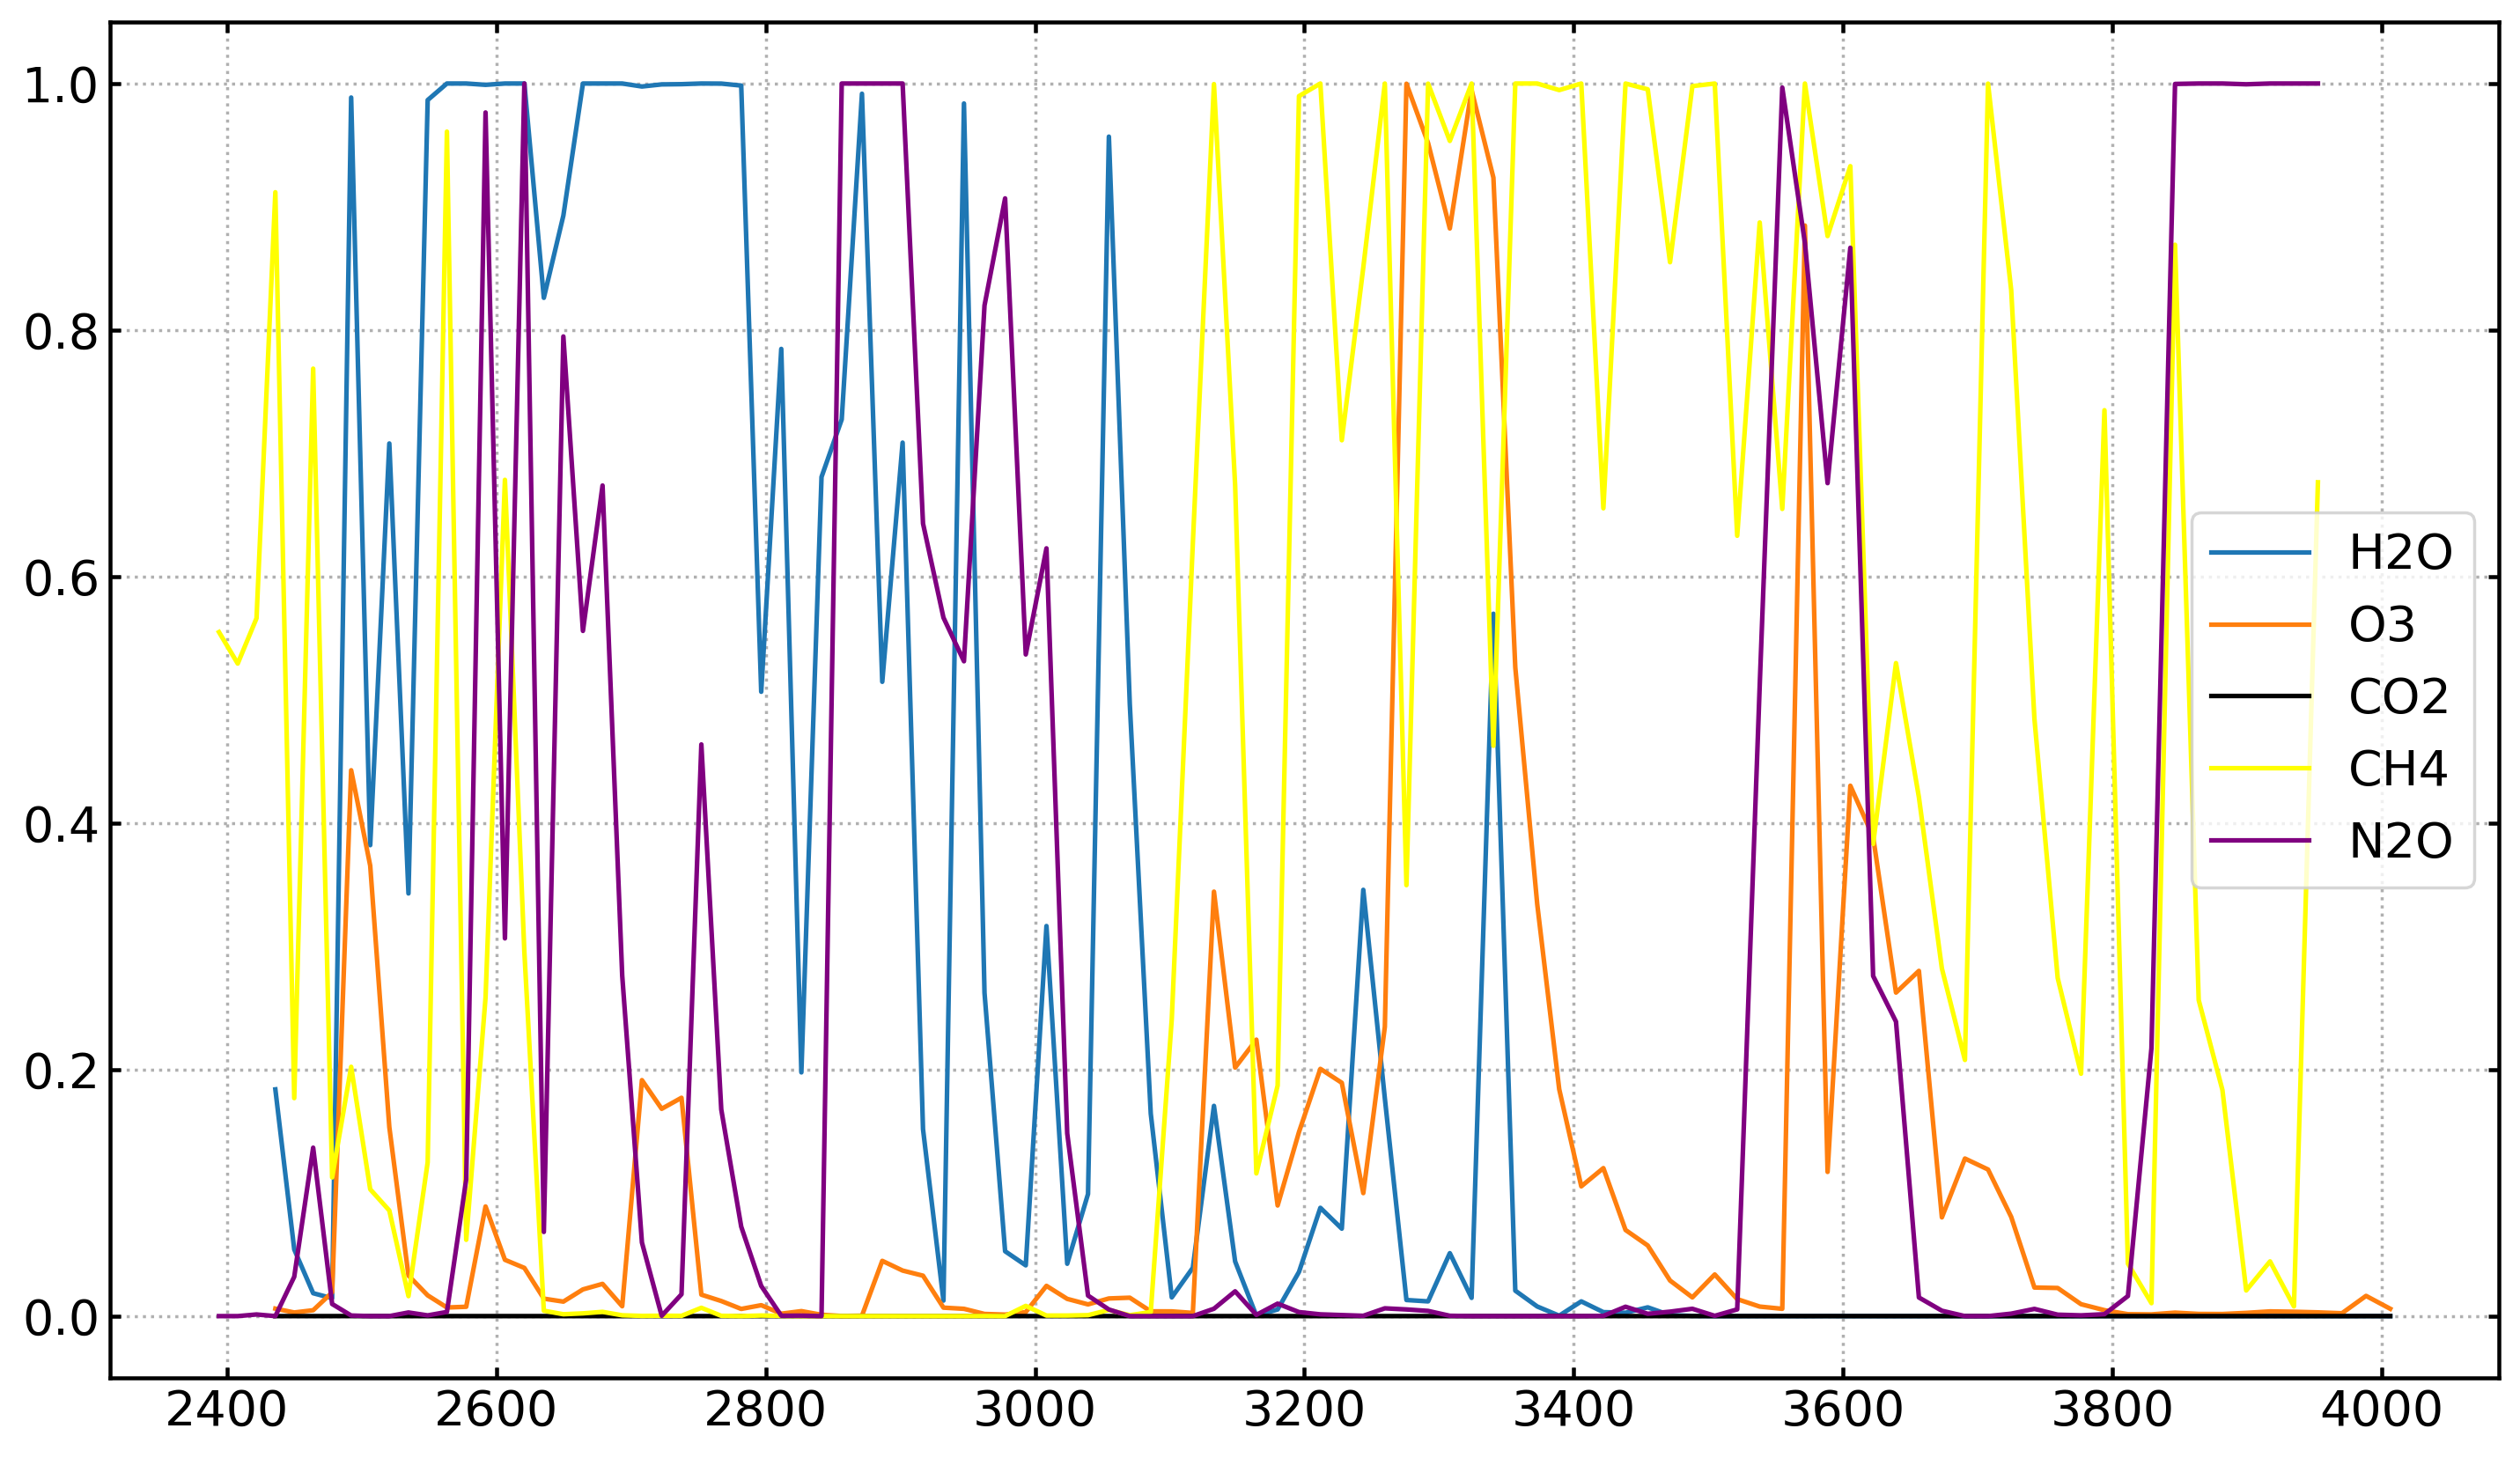

In [289]:
plt.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o, label="H2O")
plt.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3, label="O3")
plt.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2, label="CO2", color="black")
plt.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4, label="CH4", color="yellow")
plt.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o, label="N2O", color="Purple")

# plt.xlim(2550,2575)
plt.legend()
plt.show()

### Test to get the correction for the calculation of the mid-IR beam

In [72]:
def wavelength_idler_config(lambda_pump: float) -> float:
    lambda_signal = 1064.460  # nm
    lambda_signal_unc = 0.001  # nm
    lambda_pump_unc = 0.5  # nm
    
    lambda_pump_float = unc.ufloat(lambda_pump, lambda_pump_unc)
    lambda_signal_float = unc.ufloat(lambda_signal, lambda_signal_unc)
    
    lambda_idler = (1 / lambda_pump_float - 1 / lambda_signal_float)**(-1)
    return lambda_idler

In [ ]:
# Flash lamp discharges: 010853300

In [86]:
wavelength_near_ir = [
    746.000, 786.000, 
    
]
wavelength_mid_ir = [
    2493.523, 3004.617, 
]
print(f"Laservision [nm] │ Mine [nm]")
for i in range(len(wavelength_near_ir)):
    print(f"         {wavelength_mid_ir[i]:.3f} │ {wavelength_idler_config(wavelength_near_ir[i]).n:.4f} ")


Laservision [nm] │ Mine [nm]
         2493.523 │ 2493.5225 
         3004.617 │ 3004.6167 


In [104]:
wavenumber = wavelength_idler_config(wavelength_near_ir[1]).n
1 / wavenumber * 1e7 

3328.2115735706884